In [9]:
import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.layers import Lambda
from fastai.callbacks import SaveModelCallback
import pytorch_ssim as ssim
from superres import *

In [10]:
path = Path('/DATA/WAMRI/SALK/uri/Image_restoration_data/')
train_lr = path/'train_LR'
train_hr = path/'train_HR'
test_lr = path/'test_LR'
test_hr = path/'test_HR'

In [11]:
def pull_id(fn):
    return fn.split('#')[-1].split('.')[0]

def match_hr_fn(x):
    return hr_names_by_id[pull_id(x.name)]

lr_names_full = list(train_lr.glob('*.tif'))
lr_names_full.sort()
hr_names_by_id = {pull_id(hrfn.name):hrfn for hrfn in train_hr.glob('*.tif')}

In [12]:
valid_pct = 0.10
src = (SuperResItemList(lr_names_full).
       #random_split_by_pct(valid_pct).
       split_by_valid_func(lambda x: x.stem[-3] == '0').
       label_from_func(match_hr_fn))   

def get_data(src, bs, sz_lr, scale=4, tfms=None, **kwargs):
    sz_hr = sz_lr*scale
    salk_stats = ( [0.10], [0.20])
    if tfms is None: tfms = get_transforms() 
    data = (src.transform(tfms, size=sz_lr)
            .transform_labels(size=sz_hr)
            .databunch(bs=bs, **kwargs))
    return data

In [13]:
#[x.stem for x in lr_names_full if x.stem[-3] == '0']

In [14]:
ssim_loss = ssim.SSIM(mult=-1.)
ssim_loss_2 = ssim.SSIM(window_size=3, mult=-1.)
ssim_loss_3 = ssim.SSIM(window_size=32, mult=-1.)

def combo_loss(pred, targs):
    return (3 + 
            ssim_loss(pred,targs) + 
            ssim_loss_2(pred,targs) + 
            ssim_loss_3(pred,targs) + 
            F.mse_loss(pred, targs)
           )
    #return ssim_loss(pred, targs) + psnr_loss(pred, targs)/50. # + F.l1_loss(pred, targs)

def combo_loss(pred, targs):
    #pred_clamp = torch.clamp(pred,0.,1.)
    pred_clamp = pred
    return (1 + 
            ssim_loss(pred_clamp,targs) + 
            #ssim_loss_2(pred_clamp,targs) + 
            #ssim_loss_3(pred_clamp,targs) + 
            F.mse_loss(pred, targs)
           )
  
metrics = [F.mse_loss, 
           combo_loss,
           ssim.ssim,
           partial(ssim.ssim, window_size=3),
           partial(ssim.ssim, window_size=32),
           psnr]

In [15]:
n_feats = 4
n_res = 1024
n_color = 1
scale=4


norm = Lambda(lambda x: ((x - 0.10)/0.3))
denorm = Lambda(lambda x: (x*0.3 + 0.10))

class MeanShift(nn.Conv2d):
    def __init__(self, mean=0.40, std=1.0, sign=-1):
        super(MeanShift, self).__init__(1, 3, kernel_size=1)
        std = torch.Tensor([std])
        self.weight.data = torch.eye(1).view(1, 1, 1, 1) / std.view(1, 1, 1, 1)
        self.bias.data = sign * torch.Tensor([mean]) / std
        self.requires_grad = False
        
sub = MeanShift()
add = MeanShift(sign=1)

# 64,4,1
model = SrResnet(n_feats, n_res, n_color, scale)
#model = nn.Sequential(sub, model, add)
model = nn.DataParallel(model).cuda()

In [16]:
loss = F.mse_loss

In [17]:
if False:
    bs = 4
    lr_sz = 506
    data = get_data(src, bs, lr_sz, scale=scale)
    learn = Learner(data, model, loss_func=loss, metrics=metrics)
    learn.lr_find(start_lr=1e-5, end_lr=1e2)
    learn.recorder.plot()

In [18]:
def batch_learn(bs, lr_sz, lr, epochs, src, scale, 
                tfms=None, load=None, save=None, plot=True, 
                loss=F.mse_loss, save_monitor='val_loss',
                callback_fns=None):
    data = get_data(src, bs, lr_sz, scale=scale, tfms=tfms)
    if callback_fns is None: callback_fns = []
    if save: callback_fns.append(partial(SaveModelCallback, name=f'{save}_best', monitor=save_monitor))
    learn = Learner(data, model, loss_func=loss, metrics=metrics, callback_fns=callback_fns)
    if load: learn = learn.load(load)
    learn.fit_one_cycle(epochs, lr)
    if save: learn.save(save)
    if plot: learn.recorder.plot_losses()
    return learn


In [ ]:
bs = 16
lr_sz = 64
lr = 1e-2
learn = batch_learn(bs, lr_sz, lr, 20, src, scale, 
                    save='small', 
                    save_monitor='combo_loss',
                    loss=F.mse_loss)

In [ ]:
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 40, src, scale, 
                    load='small_best', save='small2', 
                    save_monitor='combo_loss',
                    loss=F.mse_loss)

In [ ]:
bs = 4
lr_sz = 506
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 20, src, scale, 
                    load='exp2_best', save='exp3', 
                    save_monitor='combo_loss',
                    loss=F.mse_loss)

In [ ]:
bs = 16
lr_sz = 256
lr = 1e-2
learn = batch_learn(bs, lr_sz, lr, 4, src, scale, load='exp2', save='exp3', loss=F.mse_loss)
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 8, src, scale, load='exp3', save='exp4', loss=combo_loss)

In [ ]:
bs = 16
lr_sz = 256
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 30, src, scale, load='exp5', save='exp6', loss=F.mse_loss)


In [ ]:
bs = 4
lr_sz = 506
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 20, src, scale, load='exp5', save='exp6', loss=F.mse_loss)

In [ ]:
bs = 4
lr_sz = 506
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 20, src, scale, load='exp5', save='exp6', loss=F.mse_loss)

In [ ]:
bs = 16
lr_sz = 24
lr = 1e-2
learn = batch_learn(bs, lr_sz, lr, 5, src, scale, save='enhance-db-1')
learn = batch_learn(bs, 2*lr_sz, lr/10, 10, src, scale, load='enhance-db-1', save='enhance-db-1.1')

In [ ]:
bs = 16
lr_sz = 96
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 5, src, scale, load='enhance-db-1.1', save='enhance-db-2')
learn = batch_learn(bs, 2*lr_sz, lr/10, 10, src, scale, load='enhance-db-2', save='enhance-db-2.1')

In [ ]:
bs = 16
lr_sz = 192
lr = 1e-3
learn = batch_learn(bs, lr_sz, lr, 5, src, scale, load='enhance-db-2.1', save='enhance-db-3')
learn = batch_learn(bs, 2*lr_sz, lr/10, 5, src, scale, load='enhance-db-3', save='enhance-db-3.1')

In [ ]:
learn.recorder.plot_losses()

In [ ]:
x,y = data.valid_ds[0]

In [ ]:
trn_tfm, val_tfm = get_transforms()
test_bs = 4
test_sz = 512 
test_out_sz = 4*test_sz

src = (SuperResItemList(lr_names_full).
       random_split_by_pct(valid_pct).
       label_from_func(match_hr_fn))

salk_stats = ([0.10], [0.20])

test_data = (SuperResItemList.from_folder(path/'newman', extensions='.tif')
             .split_by_idx([])
             .label_from_func(lambda x: x)
             .transform([val_tfm,val_tfm], sz=test_sz)
             .transform_labels(size=test_out_sz)
             .databunch(bs=test_bs))
    
test_learn = Learner(test_data, model, loss_func=loss, path='.').load('small2_best')

In [ ]:
imgs = list((path/'lores2').glob('*.tif'))


def pred_and_save(img_fn):
    img = open_grayscale(img_fn)
    pred_img = test_learn.predict(img)
    pred_img = torch.clamp(pred_img,0.,1.)
    #img_min = pred_img.min()
    #img_max = pred_img.max()
    #pred_img = (pred_img - img_min) / (img_max - img_min)
    new_img = Image(pred_img[0])
    new_img.save(img_fn.name.replace('low res', 'super res'))
    return img, new_img
    
sr_images = []
orig_images = []
fns = []
for img_fn in imgs:
    orig_img, new_img = pred_and_save(img_fn)
    fns.append(img_fn)
    sr_images.append(new_img)    
    orig_images.append(orig_img)

In [ ]:
for oi, sri, fn in zip(orig_images, sr_images, fns):
    print(fn)
    show_image(oi)
    show_image(sri)

In [ ]:
orig_images[0]

In [ ]:
sr_images[0]

In [ ]:
orig_images[1]

In [ ]:
sr_images[1]

In [22]:
bs = 4
lr_sz = 506
lr = 1e-2
data = get_data(src, bs, lr_sz, scale=scale)
learn = Learner(data, model, loss_func=loss, metrics=metrics).load('exp2_best')
preds, ys = learn.get_preds(DatasetType.Valid)
preds = torch.clamp(preds, 0.,1.)

In [24]:
idx = 11
ys[idx].std(), preds[idx].std()

(tensor(0.1217), tensor(0.1155))

In [25]:
preds[idx].min(),preds[idx].max()

(tensor(0.), tensor(1.))

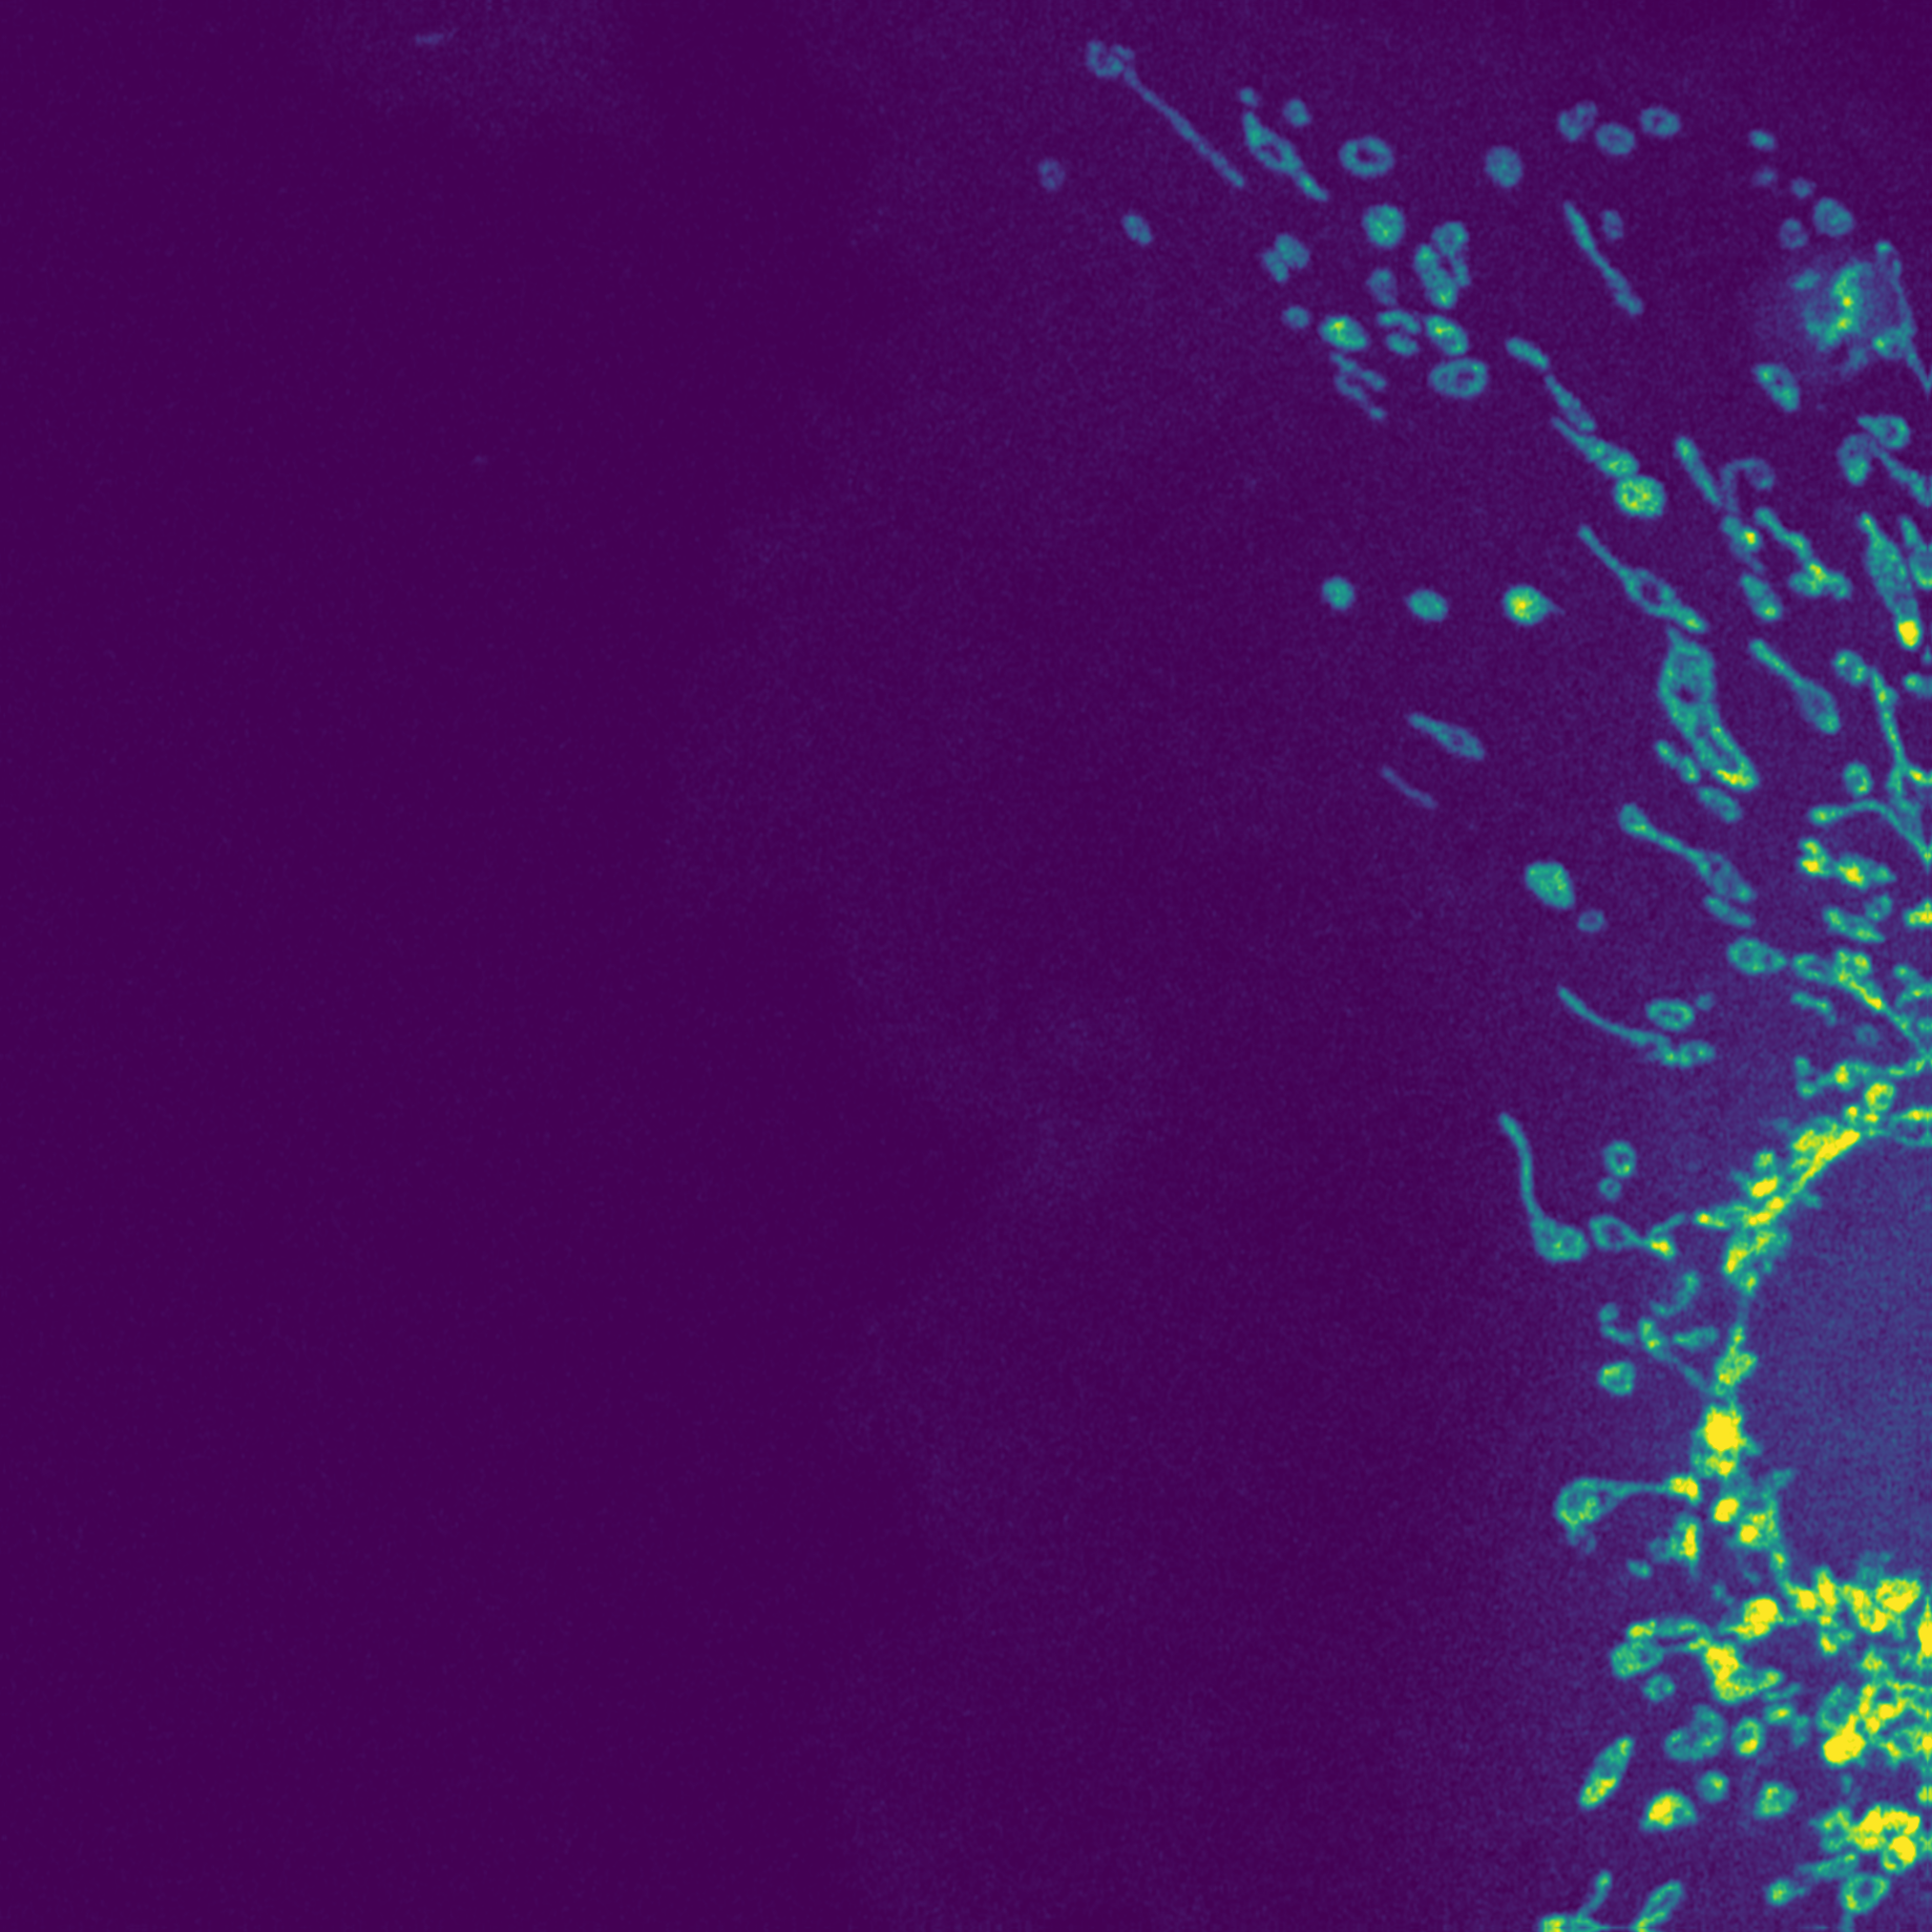

In [26]:
hr = Image(ys[idx])
hr

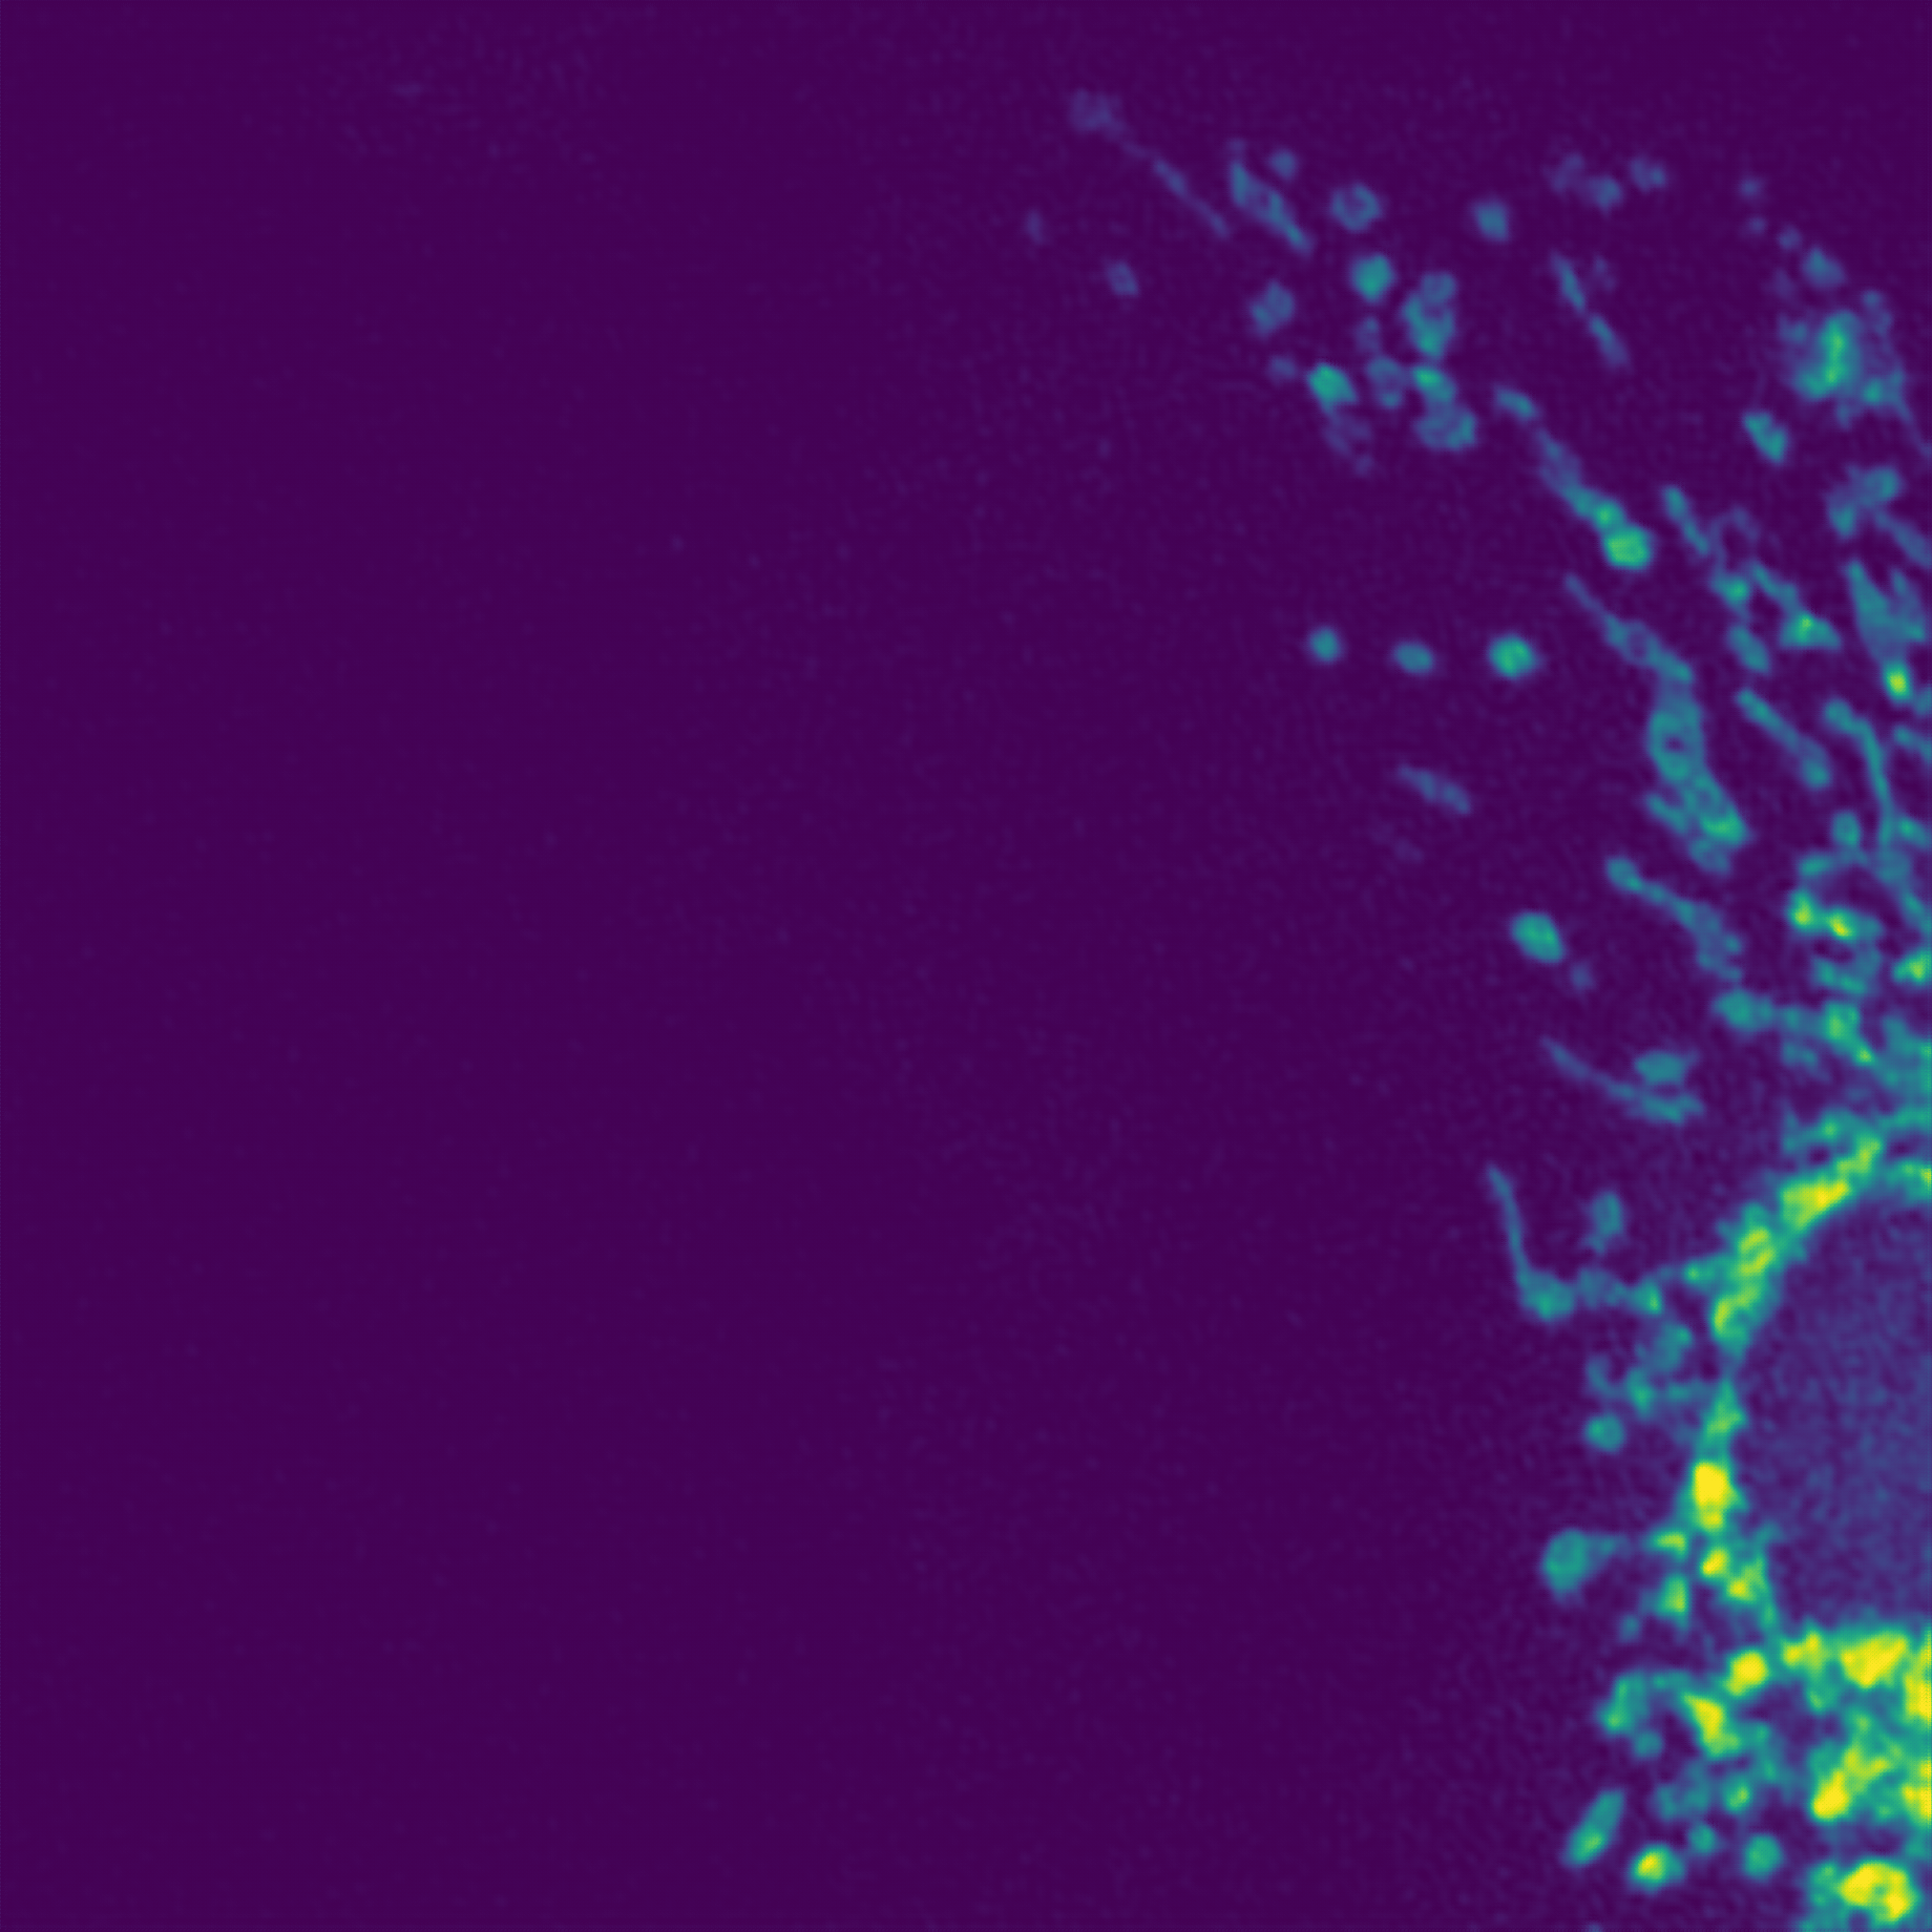

In [27]:
sr = Image(preds[idx])
sr

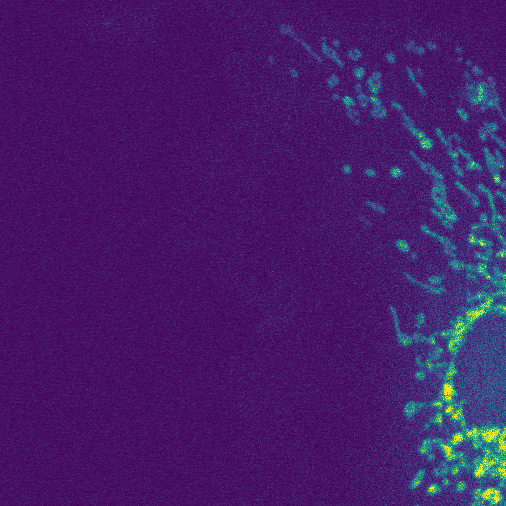

In [28]:
lr = learn.data.valid_ds[idx][0]
lr

In [29]:
ssim.ssim(sr.data[None],hr.data[None]), F.mse_loss(sr.data[None],hr.data[None])

(tensor(0.7172), tensor(0.0130))

In [21]:
#exp2_best
model = SrResnet(4, 512, 1, 4)
model = nn.DataParallel(model).cuda()

#small2_best
model = SrResnet(4, 1024, 1, 4)
model = nn.DataParallel(model).cuda()
